# E-Commerce Customer Segmentation with RFM Analysis & K-Means Clustering

### Research Question

How can we segment our customer base into distinct, actionable groups based on their historical purchasing behavior (Recency, Frequency, Monetary Value) to identify our most valuable customers and tailor retention and marketing strategies accordingly?

**Data Understanding**

The dataset e-commerce-data.csv contains transactional data for a UK-based online retailer. The columns are:

1. `InvoiceNo`: A 6-digit number uniquely assigned to each transaction. If this code starts with the letter 'C', it indicates a cancellation.

2. `StockCode`: A 5-digit number uniquely assigned to each distinct product.

3. `Description`: The name of the product.

4. `Quantity`: The quantities of each product per transaction. Negative values indicate returns.

5. `InvoiceDate`: The date and time when each transaction was generated.

6. `UnitPrice`: The price of a single unit of the product in pounds sterling (£).

7. `CustomerID`: A 5-digit number uniquely assigned to each customer. This column has missing values.

8. `Country`: The name of the country where each customer resides.

## Import Library

import library such as `pandas`, `numpy` for data manipulation, 

`matplotlib`, `seasborn` for data visualization,

`scikit-learn` for clustering

In [18]:
# Data manipulation and analysis
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# Statistical analysis
from scipy import stats
from scipy.stats import zscore

# Utilities
import warnings
import datetime as dt
from datetime import datetime, timedelta

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Open The Dataset

In [21]:
df = pd.read_csv("data.csv", encoding = 'ISO-8859-1')

In [42]:
print("📊 DATASET OVERVIEW")
print("=" * 50)
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
df.head()

📊 DATASET OVERVIEW
Dataset shape: (541909, 8)
Columns: ['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']

First 5 rows:


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [25]:
print("\n📋 DATASET INFO")
print("=" * 50)
print(df.info())


📋 DATASET INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None


In [43]:
print("\n📈 STATISTICAL SUMMARY")
print("=" * 50)
df.describe()


📈 STATISTICAL SUMMARY


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data Cleaning and Preprocessing

This is the most critical phase. We will address the issues identified above to create a clean, reliable dataset for analysis.

**Our plan:**
1.  Handle missing `CustomerID` values, as they are essential for segmentation.
2.  Clean up data types (`CustomerID` and `InvoiceDate`).
3.  Remove cancelled orders and negative quantities.
4.  Remove transactions with a `UnitPrice` of zero.
5.  Create a `TotalPrice` column for monetary analysis.

In [27]:
# Check for missing values
missing_data = df.isnull().sum()
missing_percentage = (missing_data / len(df)) * 100

In [28]:
missing_summary = pd.DataFrame({
    'Missing Count': missing_data,
    'Missing Percentage': missing_percentage
}).sort_values('Missing Percentage', ascending=False)

print("Missing Values Summary:")
print(missing_summary[missing_summary['Missing Count'] > 0])

Missing Values Summary:
             Missing Count  Missing Percentage
CustomerID          135080           24.926694
Description           1454            0.268311


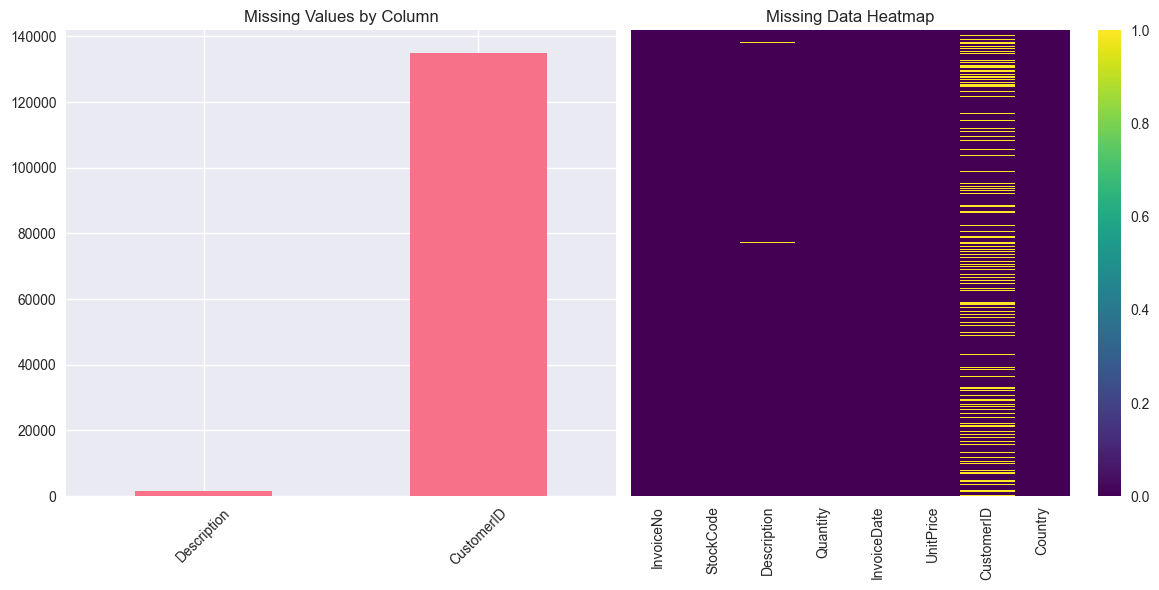

In [29]:
# Visualize missing data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
missing_data[missing_data > 0].plot(kind='bar')
plt.title('Missing Values by Column')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.heatmap(df.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.tight_layout()
plt.show()


In [53]:
# Data cleaning steps
print("\n🧹 DATA CLEANING PROCESS")
print("=" * 50)
# Store original shape
original_shape = df.shape
print(f"Original dataset shape: {original_shape}")


🧹 DATA CLEANING PROCESS
Original dataset shape: (541909, 8)


In [31]:
# Remove rows with missing CustomerID (essential for segmentation)
df_clean = df.dropna(subset=['CustomerID'])
print(f"After removing missing CustomerID: {df_clean.shape}")

After removing missing CustomerID: (406829, 8)


In [32]:
# Remove rows with missing Description
df_clean = df_clean.dropna(subset=['Description'])
print(f"After removing missing Description: {df_clean.shape}")

After removing missing Description: (406829, 8)


In [33]:
# Convert data types
df_clean['CustomerID'] = df_clean['CustomerID'].astype(int)
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

In [34]:
# Remove negative quantities and unit prices (returns/cancellations)
df_clean = df_clean[(df_clean['Quantity'] > 0) & (df_clean['UnitPrice'] > 0)]
print(f"After removing negative values: {df_clean.shape}")

After removing negative values: (397884, 8)


In [35]:
# Create total amount column
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['UnitPrice']

In [36]:
# Remove outliers using IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from key columns
for col in ['Quantity', 'UnitPrice', 'TotalAmount']:
    before_outlier_removal = df_clean.shape[0]
    df_clean = remove_outliers_iqr(df_clean, col)
    after_outlier_removal = df_clean.shape[0]
    print(f"Outliers removed from {col}: {before_outlier_removal - after_outlier_removal}")

print(f"Final cleaned dataset shape: {df_clean.shape}")
print(f"Data reduction: {((original_shape[0] - df_clean.shape[0]) / original_shape[0] * 100):.2f}%")

Outliers removed from Quantity: 25647
Outliers removed from UnitPrice: 34086
Outliers removed from TotalAmount: 13435
Final cleaned dataset shape: (324716, 9)
Data reduction: 40.08%


## Exploratory Data Analysis (EDA)

In [37]:
# Basic statistics after cleaning
print("Cleaned Dataset Summary:")
print(df_clean.describe())

Cleaned Dataset Summary:
            Quantity                    InvoiceDate      UnitPrice  \
count  324716.000000                         324716  324716.000000   
mean        7.070970  2011-07-12 20:29:17.498182912       2.123759   
min         1.000000            2010-12-01 08:26:00       0.001000   
25%         2.000000            2011-04-08 09:15:00       0.950000   
50%         5.000000            2011-08-03 14:07:00       1.650000   
75%        12.000000            2011-10-23 15:11:00       2.950000   
max        27.000000            2011-12-09 12:50:00       7.500000   
std         6.486069                            NaN       1.500057   

          CustomerID    TotalAmount  
count  324716.000000  324716.000000  
mean    15338.947603      10.854211  
min     12347.000000       0.001000  
25%     14019.000000       3.750000  
50%     15275.000000       9.900000  
75%     16842.000000      16.500000  
max     18287.000000      37.700000  
std      1709.315578       8.235695  


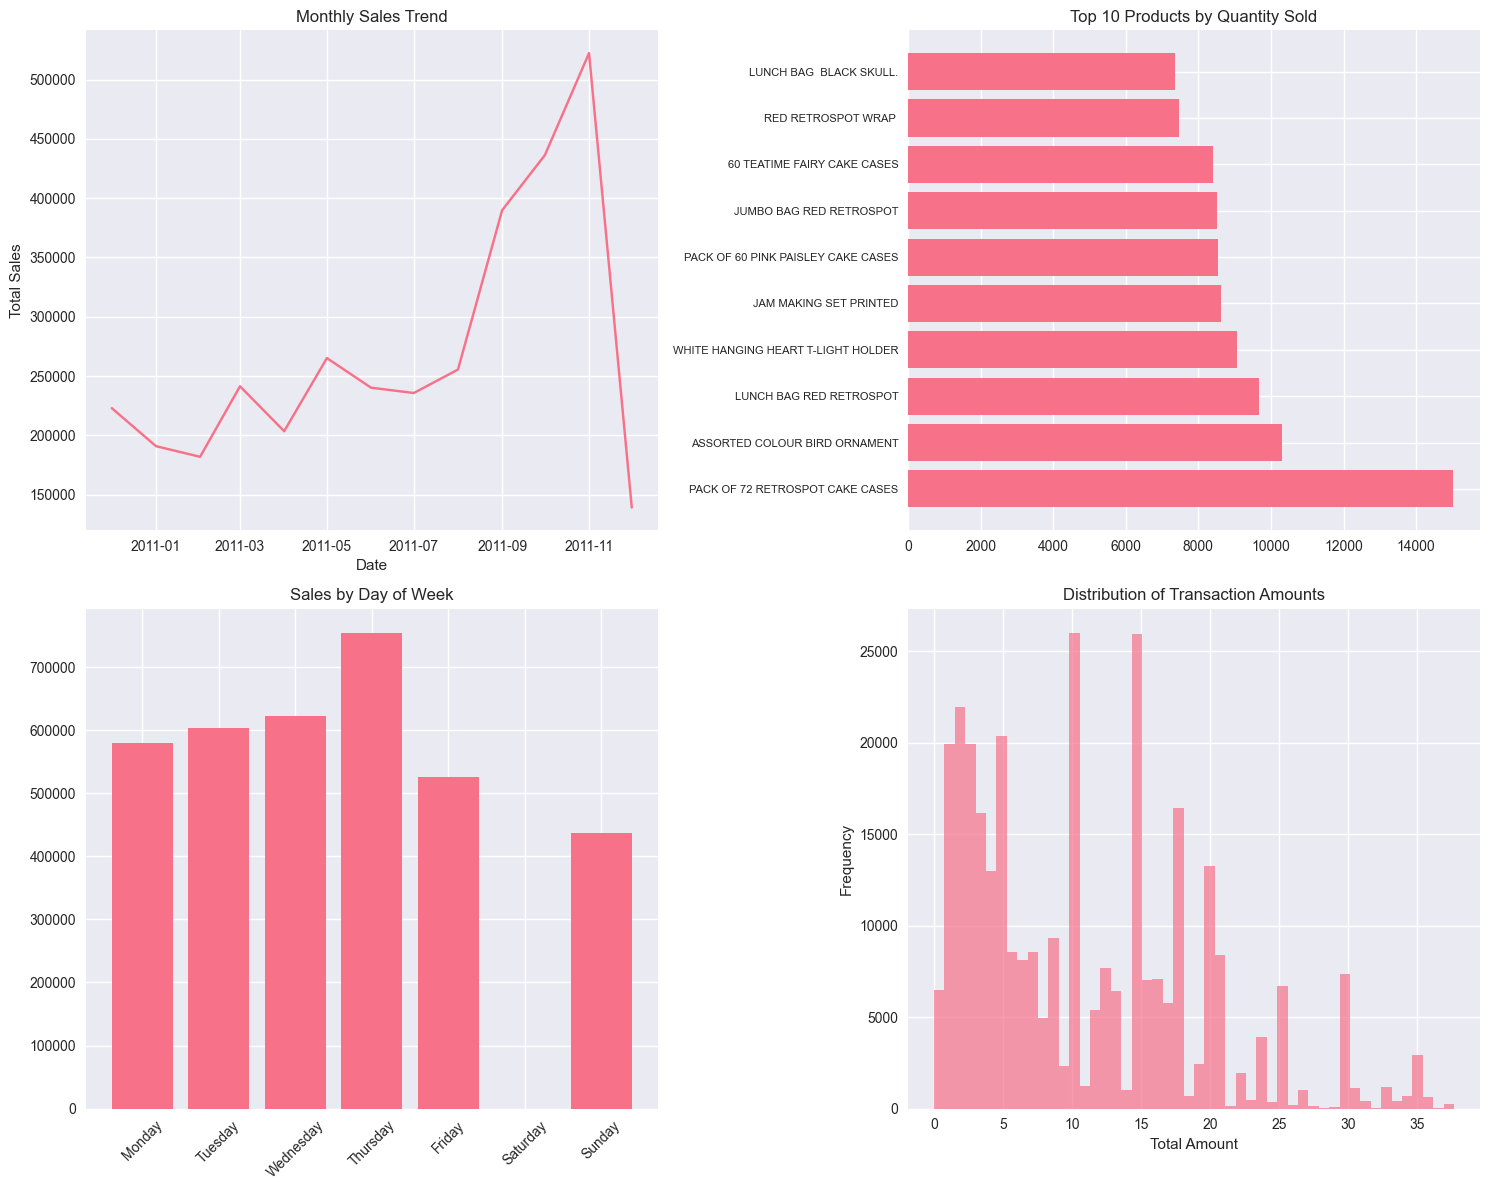

In [41]:
# Time series analysis
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()

# Time series analysis
df_clean['Year'] = df_clean['InvoiceDate'].dt.year
df_clean['Month'] = df_clean['InvoiceDate'].dt.month
df_clean['DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Sales over time
monthly_sales = df_clean.groupby(['Year', 'Month'])['TotalAmount'].sum().reset_index()
monthly_sales['Date'] = pd.to_datetime(monthly_sales[['Year', 'Month']].assign(day=1))
axes[0, 0].plot(monthly_sales['Date'], monthly_sales['TotalAmount'])
axes[0, 0].set_title('Monthly Sales Trend')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Total Sales')

# Top products
top_products = df_clean.groupby('Description')['Quantity'].sum().nlargest(10)
axes[0, 1].barh(range(len(top_products)), top_products.values)
axes[0, 1].set_yticks(range(len(top_products)))
axes[0, 1].set_yticklabels(top_products.index, fontsize=8)
axes[0, 1].set_title('Top 10 Products by Quantity Sold')

# Sales by day of week
daily_sales = df_clean.groupby('DayOfWeek')['TotalAmount'].sum()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_sales = daily_sales.reindex(day_order)
axes[1, 0].bar(daily_sales.index, daily_sales.values)
axes[1, 0].set_title('Sales by Day of Week')
axes[1, 0].tick_params(axis='x', rotation=45)

# Distribution of total amount
axes[1, 1].hist(df_clean['TotalAmount'], bins=50, alpha=0.7)
axes[1, 1].set_title('Distribution of Transaction Amounts')
axes[1, 1].set_xlabel('Total Amount')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

## RFM Analysis (Recency, Frequency, Monetary)

In [44]:
# Calculate the reference date (latest date + 1 day)
reference_date = df_clean['InvoiceDate'].max() + timedelta(days=1)
print(f"Reference date for recency calculation: {reference_date}")

# Calculate RFM metrics for each customer
rfm_data = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',  # Frequency
    'TotalAmount': 'sum'  # Monetary
}).reset_index()

Reference date for recency calculation: 2011-12-10 12:50:00


In [45]:
# Rename columns
rfm_data.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']

print("RFM Data Summary:")
print(rfm_data.describe())

RFM Data Summary:
         CustomerID      Recency    Frequency      Monetary
count   4146.000000  4146.000000  4146.000000   4146.000000
mean   15296.229378    93.181380     3.918234    850.105138
std     1718.519565   100.015984     6.813902   1767.635549
min    12347.000000     1.000000     1.000000      1.700000
25%    13819.500000    18.000000     1.000000    173.970000
50%    15290.500000    51.000000     2.000000    405.625000
75%    16775.750000   145.000000     4.000000    964.527500
max    18287.000000   374.000000   193.000000  70409.910000


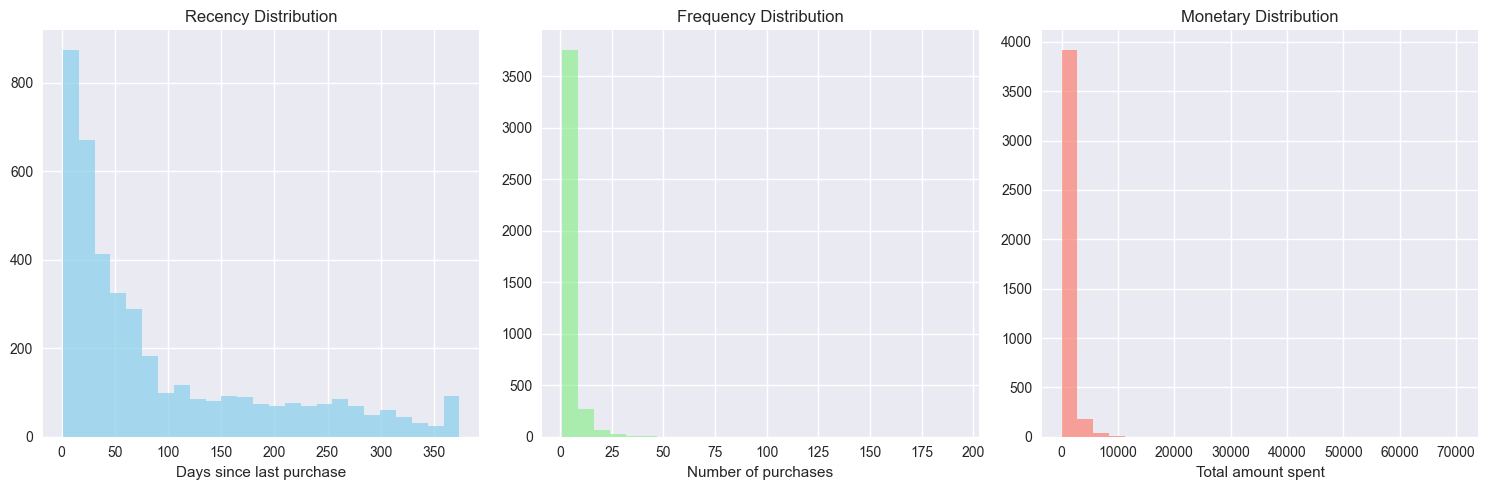

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(rfm_data['Recency'], bins=25, alpha=0.7, color='skyblue')
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days since last purchase')

axes[1].hist(rfm_data['Frequency'], bins=25, alpha=0.7, color='lightgreen')
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of purchases')

axes[2].hist(rfm_data['Monetary'], bins=25, alpha=0.7, color='salmon')
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total amount spent')

plt.tight_layout()
plt.show()

In [54]:
print("\n🔗 CORRELATION ANALYSIS")
print("=" * 50)
# Calculate correlation matrix
correlation_matrix = rfm_data[['Recency', 'Frequency', 'Monetary']].corr()
print("RFM Correlation Matrix:")
print(correlation_matrix)


🔗 CORRELATION ANALYSIS
RFM Correlation Matrix:
            Recency  Frequency  Monetary
Recency    1.000000  -0.260702 -0.235751
Frequency -0.260702   1.000000  0.793450
Monetary  -0.235751   0.793450  1.000000


### RFM CORRELATION ANALYSIS

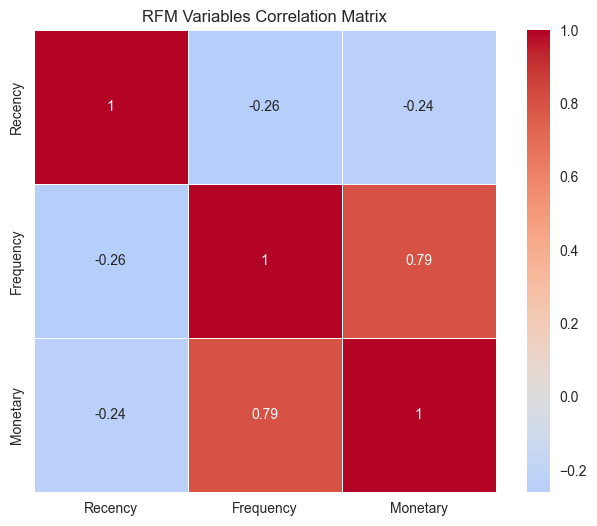

In [51]:
# Visualize correlation
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('RFM Variables Correlation Matrix')
plt.show()

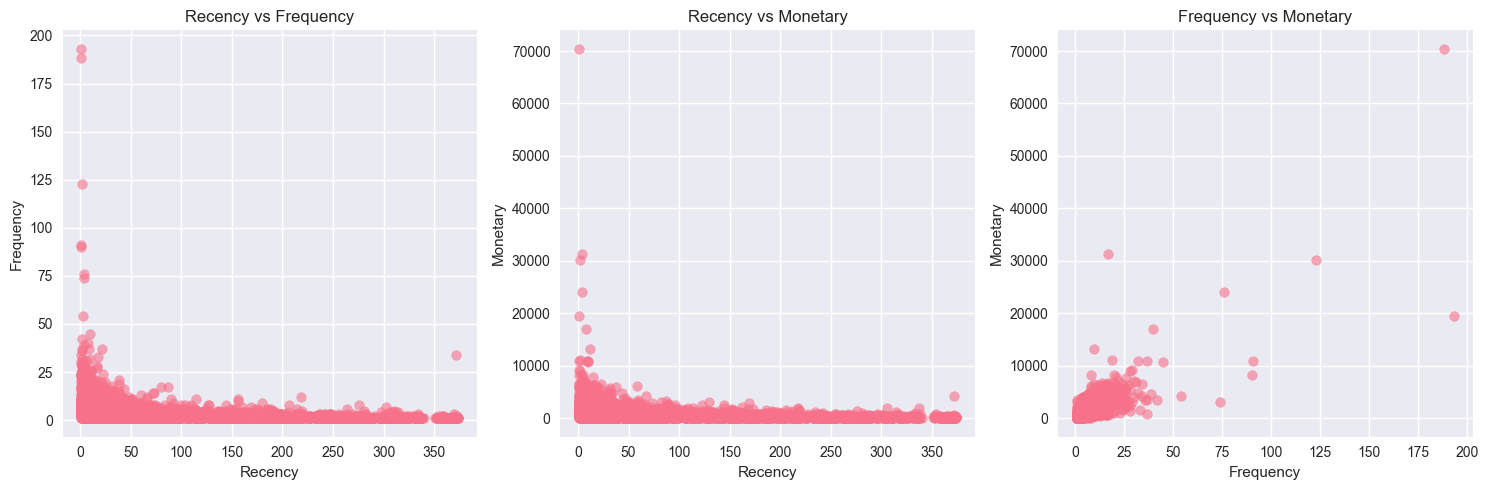

In [52]:
# Scatter plots for relationships
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].scatter(rfm_data['Recency'], rfm_data['Frequency'], alpha=0.6)
axes[0].set_xlabel('Recency')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Recency vs Frequency')

axes[1].scatter(rfm_data['Recency'], rfm_data['Monetary'], alpha=0.6)
axes[1].set_xlabel('Recency')
axes[1].set_ylabel('Monetary')
axes[1].set_title('Recency vs Monetary')

axes[2].scatter(rfm_data['Frequency'], rfm_data['Monetary'], alpha=0.6)
axes[2].set_xlabel('Frequency')
axes[2].set_ylabel('Monetary')
axes[2].set_title('Frequency vs Monetary')

plt.tight_layout()
plt.show()

In [56]:
print("\n🚨 ANOMALY DETECTION")
print("=" * 50)

# Z-score method for anomaly detection
rfm_zscore = rfm_data.copy()
for col in ['Recency', 'Frequency', 'Monetary']:
    rfm_zscore[f'{col}_zscore'] = np.abs(zscore(rfm_data[col]))

# Identify anomalies (z-score > 3)
anomaly_threshold = 3
anomalies = rfm_zscore[
    (rfm_zscore['Recency_zscore'] > anomaly_threshold) |
    (rfm_zscore['Frequency_zscore'] > anomaly_threshold) |
    (rfm_zscore['Monetary_zscore'] > anomaly_threshold)
]

print(f"Number of anomalies detected: {len(anomalies)}")
print(f"Percentage of anomalies: {(len(anomalies) / len(rfm_data) * 100):.2f}%")

if len(anomalies) > 0:
    print("\nTop 5 anomalies:")
    print(anomalies.nlargest(5, 'Monetary')[['CustomerID', 'Recency', 'Frequency', 'Monetary']])


🚨 ANOMALY DETECTION
Number of anomalies detected: 62
Percentage of anomalies: 1.50%

Top 5 anomalies:
      CustomerID  Recency  Frequency  Monetary
1804       14911        1        188  70409.91
1232       14096        4         17  31267.34
3842       17841        2        123  30169.07
536        13089        4         76  23984.91
319        12748        1        193  19543.81


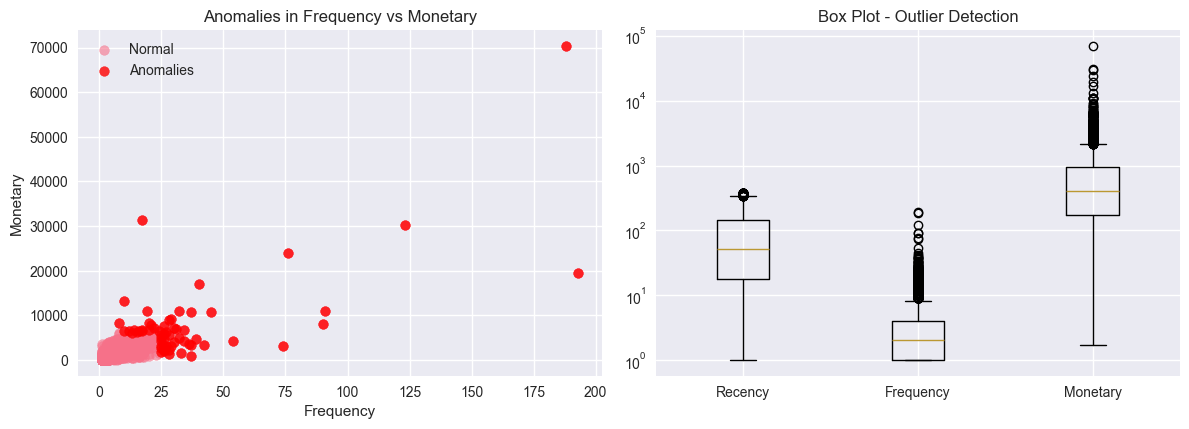

In [57]:
# Visualize anomalies
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.scatter(rfm_data['Frequency'], rfm_data['Monetary'], alpha=0.6, label='Normal')
if len(anomalies) > 0:
    plt.scatter(anomalies['Frequency'], anomalies['Monetary'], 
                color='red', alpha=0.8, label='Anomalies')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.title('Anomalies in Frequency vs Monetary')
plt.legend()

plt.subplot(2, 2, 2)
plt.boxplot([rfm_data['Recency'], rfm_data['Frequency'], rfm_data['Monetary']], 
            labels=['Recency', 'Frequency', 'Monetary'])
plt.title('Box Plot - Outlier Detection')
plt.yscale('log')

plt.tight_layout()
plt.show()

### Clustering Preprocess

In [58]:
print("\n⚙️ DATA PREPROCESSING FOR CLUSTERING")
print("=" * 50)

# Remove extreme anomalies for better clustering
rfm_for_clustering = rfm_data[
    (rfm_zscore['Recency_zscore'] <= anomaly_threshold) &
    (rfm_zscore['Frequency_zscore'] <= anomaly_threshold) &
    (rfm_zscore['Monetary_zscore'] <= anomaly_threshold)
].copy()

print(f"Data points after anomaly removal: {len(rfm_for_clustering)}")

# Log transformation for skewed data
rfm_for_clustering['Frequency_log'] = np.log1p(rfm_for_clustering['Frequency'])
rfm_for_clustering['Monetary_log'] = np.log1p(rfm_for_clustering['Monetary'])

# Standardize the features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_for_clustering[['Recency', 'Frequency_log', 'Monetary_log']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency_scaled', 'Frequency_scaled', 'Monetary_scaled'])

print("Scaled data summary:")
print(rfm_scaled_df.describe())


⚙️ DATA PREPROCESSING FOR CLUSTERING
Data points after anomaly removal: 4084
Scaled data summary:
       Recency_scaled  Frequency_scaled  Monetary_scaled
count    4.084000e+03      4.084000e+03     4.084000e+03
mean    -1.217874e-17      2.705421e-16     3.514438e-16
std      1.000122e+00      1.000122e+00     1.000122e+00
min     -9.332779e-01     -9.741421e-01    -4.082219e+00
25%     -7.534432e-01     -9.741421e-01    -6.695461e-01
50%     -4.237462e-01     -2.970830e-01     2.429847e-02
75%      5.453631e-01      5.559106e-01     7.201492e-01
max      2.793297e+00      3.243403e+00     2.270102e+00


## Determining Number of Cluster

In [59]:
# Elbow method
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(rfm_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(rfm_scaled, kmeans.labels_))

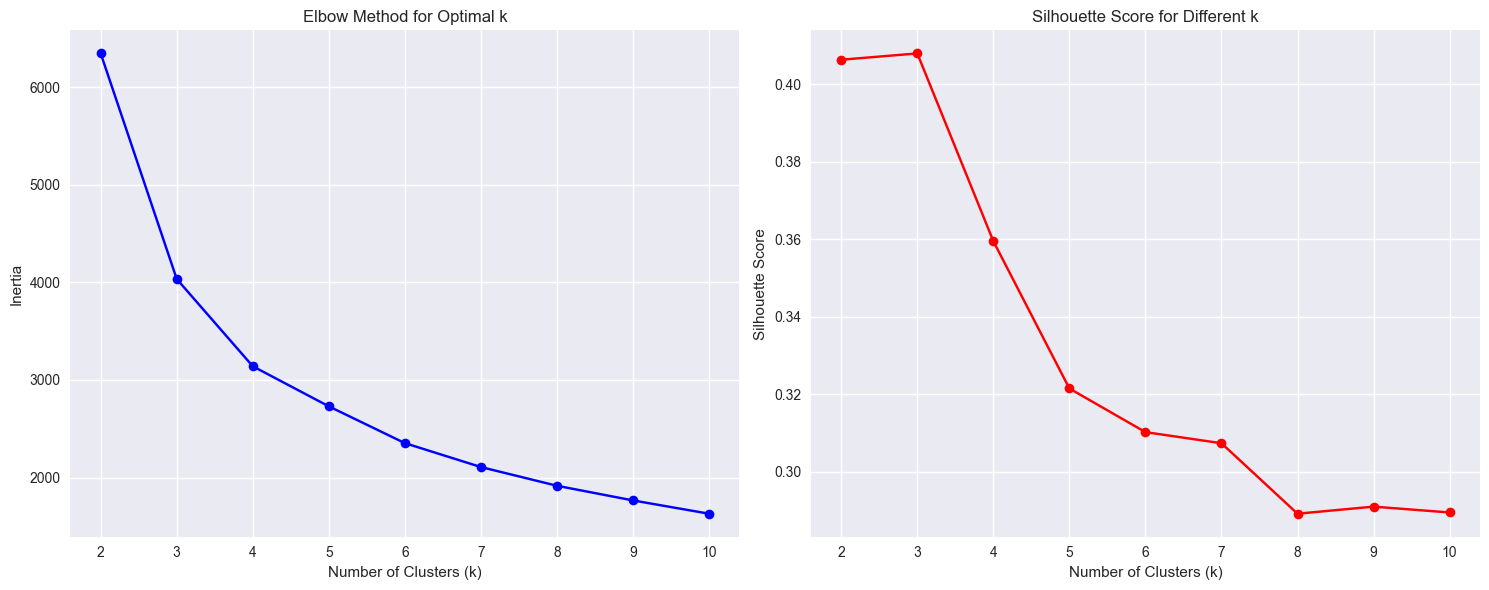

Optimal number of clusters based on silhouette score: 3
Best silhouette score: 0.408


In [62]:
# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Elbow method
axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True)

# Silhouette scores
axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score for Different k')
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters based on silhouette score: {optimal_k_silhouette}")
print(f"Best silhouette score: {max(silhouette_scores):.3f}")

## Build Clustering Model

In [63]:
# Train the final model with optimal k
optimal_k = optimal_k_silhouette
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(rfm_scaled)

# Add cluster labels to the dataframe
rfm_for_clustering['Cluster'] = cluster_labels

print(f"Model trained with {optimal_k} clusters")
print(f"Final silhouette score: {silhouette_score(rfm_scaled, cluster_labels):.3f}")

Model trained with 3 clusters
Final silhouette score: 0.408


In [64]:
# Cluster distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCluster distribution:")
for i, count in enumerate(cluster_counts):
    print(f"Cluster {i}: {count} customers ({count/len(cluster_labels)*100:.1f}%)")


Cluster distribution:
Cluster 0: 1428 customers (35.0%)
Cluster 1: 932 customers (22.8%)
Cluster 2: 1724 customers (42.2%)


### Cluster Interpretation

In [65]:
print("\n📊 CLUSTER ANALYSIS AND INTERPRETATION")
print("=" * 50)

# Calculate cluster characteristics
cluster_summary = rfm_for_clustering.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median'],
    'CustomerID': 'count'
}).round(2)

cluster_summary.columns = ['Recency_Mean', 'Recency_Median', 'Frequency_Mean', 'Frequency_Median',
                          'Monetary_Mean', 'Monetary_Median', 'Customer_Count']

print("Cluster Characteristics:")
print(cluster_summary)

# Define cluster personas based on RFM characteristics
def define_cluster_persona(row):
    recency = row['Recency_Mean']
    frequency = row['Frequency_Mean']
    monetary = row['Monetary_Mean']
    
    if recency <= 50 and frequency >= 10 and monetary >= 1000:
        return "Champions"
    elif recency <= 100 and frequency >= 5 and monetary >= 500:
        return "Loyal Customers"
    elif recency <= 50 and frequency < 5:
        return "New Customers"
    elif recency > 200 and frequency >= 5:
        return "At Risk"
    elif recency > 300:
        return "Lost Customers"
    elif frequency < 3 and monetary < 200:
        return "Price Sensitive"
    else:
        return "Potential Loyalists"

cluster_summary['Persona'] = cluster_summary.apply(define_cluster_persona, axis=1)
print("\nCluster Personas:")
print(cluster_summary[['Customer_Count', 'Persona']])


📊 CLUSTER ANALYSIS AND INTERPRETATION
Cluster Characteristics:
         Recency_Mean  Recency_Median  Frequency_Mean  Frequency_Median  \
Cluster                                                                   
0               34.02            22.0            6.78               5.0   
1              255.93           253.5            1.32               1.0   
2               57.13            50.0            1.77               2.0   

         Monetary_Mean  Monetary_Median  Customer_Count  
Cluster                                                  
0              1574.75          1238.92            1428  
1               220.17           157.30             932  
2               322.74           267.76            1724  

Cluster Personas:
         Customer_Count              Persona
Cluster                                     
0                  1428      Loyal Customers
1                   932  Potential Loyalists
2                  1724  Potential Loyalists


## Clustering Visualization

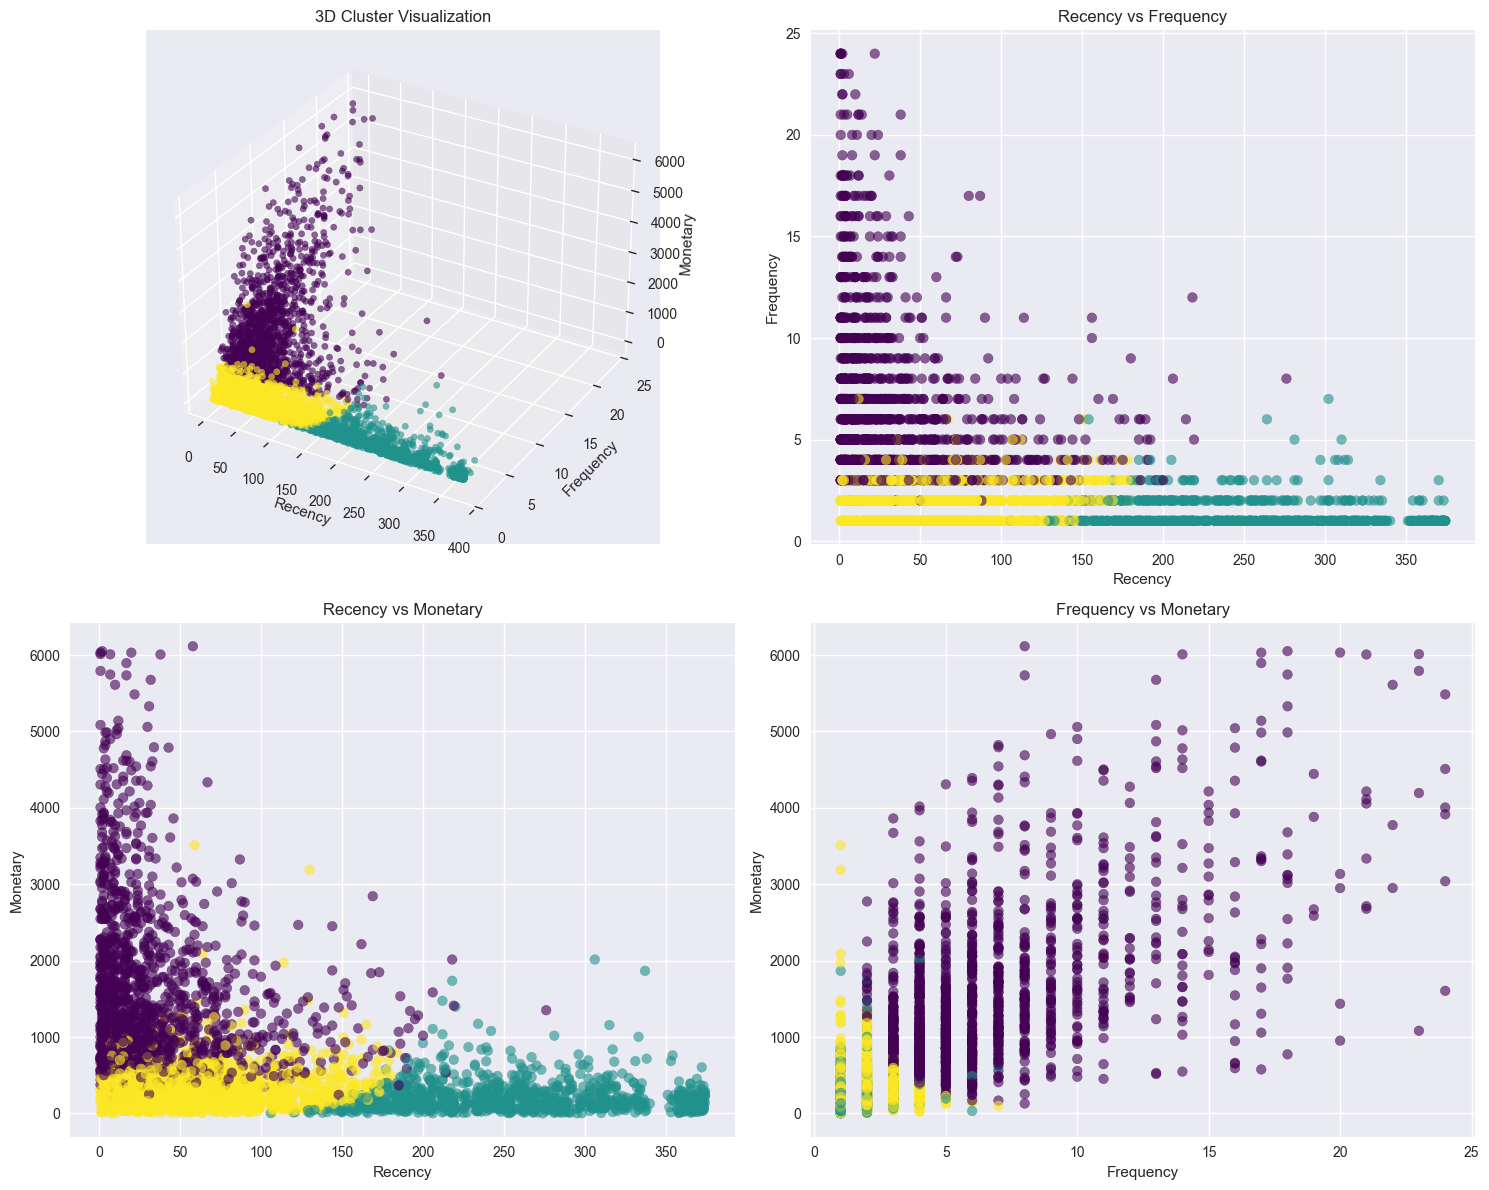

In [68]:
# 2D projections
fig = plt.figure(figsize=(15, 12))

ax1 = fig.add_subplot(221, projection='3d')
scatter = ax1.scatter(rfm_for_clustering['Recency'], 
                     rfm_for_clustering['Frequency'], 
                     rfm_for_clustering['Monetary'],
                     c=rfm_for_clustering['Cluster'], 
                     cmap='viridis', alpha=0.6)
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary')
ax1.set_title('3D Cluster Visualization')

ax2 = fig.add_subplot(222)
scatter2 = ax2.scatter(rfm_for_clustering['Recency'], 
                      rfm_for_clustering['Frequency'],
                      c=rfm_for_clustering['Cluster'], 
                      cmap='viridis', alpha=0.6)
ax2.set_xlabel('Recency')
ax2.set_ylabel('Frequency')
ax2.set_title('Recency vs Frequency')

ax3 = fig.add_subplot(223)
scatter3 = ax3.scatter(rfm_for_clustering['Recency'], 
                      rfm_for_clustering['Monetary'],
                      c=rfm_for_clustering['Cluster'], 
                      cmap='viridis', alpha=0.6)
ax3.set_xlabel('Recency')
ax3.set_ylabel('Monetary')
ax3.set_title('Recency vs Monetary')

ax4 = fig.add_subplot(224)
scatter4 = ax4.scatter(rfm_for_clustering['Frequency'], 
                      rfm_for_clustering['Monetary'],
                      c=rfm_for_clustering['Cluster'], 
                      cmap='viridis', alpha=0.6)
ax4.set_xlabel('Frequency')
ax4.set_ylabel('Monetary')
ax4.set_title('Frequency vs Monetary')

plt.tight_layout()
plt.show()

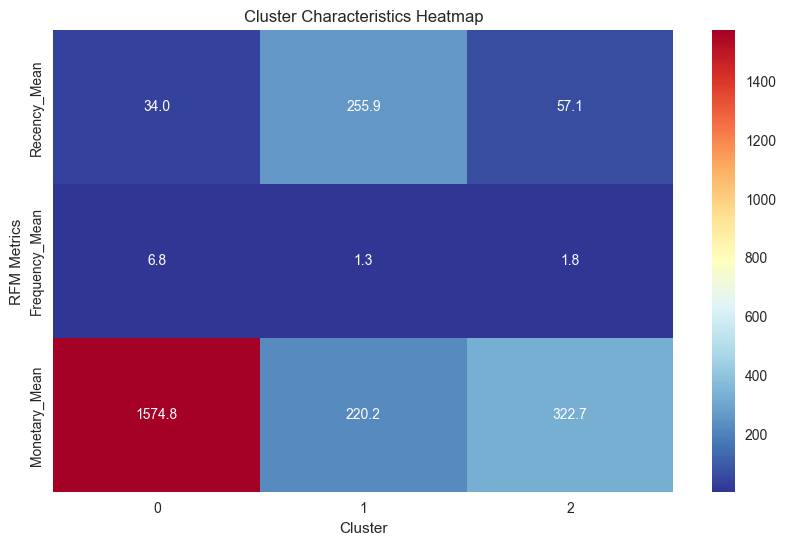

In [70]:
# Cluster heatmap
plt.figure(figsize=(10, 6))
cluster_heatmap_data = cluster_summary[['Recency_Mean', 'Frequency_Mean', 'Monetary_Mean']].T
sns.heatmap(cluster_heatmap_data, annot=True, cmap='RdYlBu_r', fmt='.1f')
plt.title('Cluster Characteristics Heatmap')
plt.ylabel('RFM Metrics')
plt.xlabel('Cluster')
plt.show()

## PCA Visualization

In [71]:
# Apply PCA for 2D visualization
pca = PCA(n_components=2)
rfm_pca = pca.fit_transform(rfm_scaled)

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total explained variance: {sum(pca.explained_variance_ratio_):.3f}")

Explained variance ratio: [0.70611943 0.207604  ]
Total explained variance: 0.914


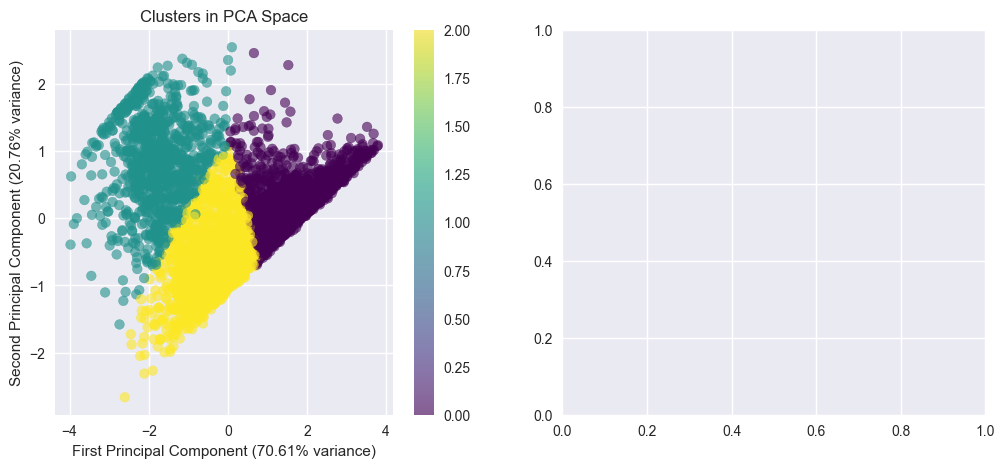

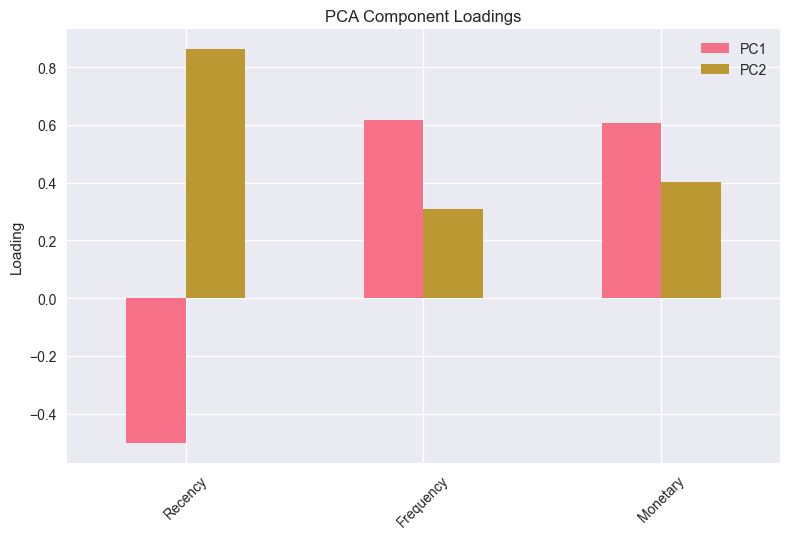

In [72]:
# PCA visualization
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
scatter = plt.scatter(rfm_pca[:, 0], rfm_pca[:, 1], 
                     c=cluster_labels, cmap='viridis', alpha=0.6)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Clusters in PCA Space')
plt.colorbar(scatter)

# Feature importance in PCA
plt.subplot(1, 2, 2)
feature_names = ['Recency', 'Frequency', 'Monetary']
pca_components = pd.DataFrame(pca.components_.T, 
                             columns=['PC1', 'PC2'], 
                             index=feature_names)
pca_components.plot(kind='bar')
plt.title('PCA Component Loadings')
plt.ylabel('Loading')
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()

## Business Metrics Insight

In [73]:
print("\n💡 BUSINESS INSIGHTS AND RECOMMENDATIONS")
print("=" * 50)

# Calculate business metrics for each cluster
business_metrics = rfm_for_clustering.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean', 
    'Monetary': ['mean', 'sum'],
    'CustomerID': 'count'
}).round(2)

business_metrics.columns = ['Avg_Recency', 'Avg_Frequency', 'Avg_Monetary', 'Total_Revenue', 'Customer_Count']
business_metrics['Revenue_Per_Customer'] = business_metrics['Total_Revenue'] / business_metrics['Customer_Count']
business_metrics['Revenue_Percentage'] = (business_metrics['Total_Revenue'] / business_metrics['Total_Revenue'].sum() * 100).round(1)

print("Business Metrics by Cluster:")
print(business_metrics)

# Create comprehensive cluster profiles
cluster_profiles = pd.DataFrame({
    'Cluster': range(optimal_k),
    'Persona': cluster_summary['Persona'].values,
    'Size': business_metrics['Customer_Count'].values,
    'Size_Percentage': (business_metrics['Customer_Count'] / business_metrics['Customer_Count'].sum() * 100).round(1),
    'Avg_Recency': business_metrics['Avg_Recency'].values,
    'Avg_Frequency': business_metrics['Avg_Frequency'].values,
    'Avg_Monetary': business_metrics['Avg_Monetary'].values,
    'Revenue_Contribution': business_metrics['Revenue_Percentage'].values
})

print("\nDetailed Cluster Profiles:")
print(cluster_profiles)


💡 BUSINESS INSIGHTS AND RECOMMENDATIONS
Business Metrics by Cluster:
         Avg_Recency  Avg_Frequency  Avg_Monetary  Total_Revenue  \
Cluster                                                            
0              34.02           6.78       1574.75     2248738.54   
1             255.93           1.32        220.17      205198.15   
2              57.13           1.77        322.74      556399.93   

         Customer_Count  Revenue_Per_Customer  Revenue_Percentage  
Cluster                                                            
0                  1428           1574.746877                74.7  
1                   932            220.169689                 6.8  
2                  1724            322.737778                18.5  

Detailed Cluster Profiles:
         Cluster              Persona  Size  Size_Percentage  Avg_Recency  \
Cluster                                                                     
0              0      Loyal Customers  1428             35.0       

In [74]:
def generate_marketing_strategy(persona, metrics):
    strategies = {
        "Champions": {
            "description": "Best customers with high value, frequency, and recent purchases",
            "strategy": [
                "Reward with exclusive offers and early access to new products",
                "Implement VIP loyalty program with premium benefits",
                "Use as brand ambassadors for referral programs",
                "Provide personalized customer service"
            ]
        },
        "Loyal Customers": {
            "description": "Consistent customers with good value and regular purchases",
            "strategy": [
                "Maintain engagement with regular communication",
                "Offer loyalty rewards and points programs",
                "Cross-sell and upsell complementary products",
                "Gather feedback for product improvement"
            ]
        },
        "New Customers": {
            "description": "Recent customers with potential for growth",
            "strategy": [
                "Welcome series with onboarding content",
                "First-purchase incentives and discounts",
                "Educational content about product benefits",
                "Follow-up campaigns to encourage repeat purchases"
            ]
        },
        "At Risk": {
            "description": "Previously good customers showing signs of churn",
            "strategy": [
                "Win-back campaigns with special offers",
                "Personalized recommendations based on past purchases",
                "Survey to understand reasons for decreased activity",
                "Limited-time exclusive deals to re-engage"
            ]
        },
        "Lost Customers": {
            "description": "Customers who haven't purchased in a long time",
            "strategy": [
                "Aggressive win-back campaigns with significant discounts",
                "Re-introduction to new products and improvements",
                "Apologetic messaging acknowledging absence",
                "Last-chance offers before removing from active campaigns"
            ]
        },
        "Price Sensitive": {
            "description": "Customers with low frequency and monetary value",
            "strategy": [
                "Focus on value propositions and cost savings",
                "Promote sales, discounts, and bundle deals",
                "Highlight product quality and durability",
                "Gradual upselling with small incremental offers"
            ]
        },
        "Potential Loyalists": {
            "description": "Customers with potential to become loyal",
            "strategy": [
                "Nurture with consistent engagement campaigns",
                "Offer loyalty program enrollment incentives",
                "Provide excellent customer service experiences",
                "Gradually increase purchase frequency through targeted offers"
            ]
        }
    }
    
    return strategies.get(persona, {"description": "Custom segment", "strategy": ["Develop targeted approach"]})

In [75]:
print("\n🎯 MARKETING STRATEGY RECOMMENDATIONS")
print("=" * 60)

for idx, row in cluster_profiles.iterrows():
    persona = row['Persona']
    strategy_info = generate_marketing_strategy(persona, row)
    
    print(f"\n📊 CLUSTER {idx}: {persona}")
    print(f"Size: {row['Size']} customers ({row['Size_Percentage']}%)")
    print(f"Revenue Contribution: {row['Revenue_Contribution']}%")
    print(f"Avg Recency: {row['Avg_Recency']:.0f} days")
    print(f"Avg Frequency: {row['Avg_Frequency']:.1f} purchases")
    print(f"Avg Monetary: ${row['Avg_Monetary']:.2f}")
    print(f"\nDescription: {strategy_info['description']}")
    print("Recommended Strategies:")
    for i, strategy in enumerate(strategy_info['strategy'], 1):
        print(f"  {i}. {strategy}")
    print("-" * 60)


🎯 MARKETING STRATEGY RECOMMENDATIONS

📊 CLUSTER 0: Loyal Customers
Size: 1428 customers (35.0%)
Revenue Contribution: 74.7%
Avg Recency: 34 days
Avg Frequency: 6.8 purchases
Avg Monetary: $1574.75

Description: Consistent customers with good value and regular purchases
Recommended Strategies:
  1. Maintain engagement with regular communication
  2. Offer loyalty rewards and points programs
  3. Cross-sell and upsell complementary products
  4. Gather feedback for product improvement
------------------------------------------------------------

📊 CLUSTER 1: Potential Loyalists
Size: 932 customers (22.8%)
Revenue Contribution: 6.8%
Avg Recency: 256 days
Avg Frequency: 1.3 purchases
Avg Monetary: $220.17

Description: Customers with potential to become loyal
Recommended Strategies:
  1. Nurture with consistent engagement campaigns
  2. Offer loyalty program enrollment incentives
  3. Provide excellent customer service experiences
  4. Gradually increase purchase frequency through targete

In [76]:
print("\n✅ MODEL EVALUATION AND VALIDATION")
print("=" * 50)

# Silhouette analysis
silhouette_avg = silhouette_score(rfm_scaled, cluster_labels)
print(f"Average Silhouette Score: {silhouette_avg:.3f}")

# Cluster stability (using different random states)
stability_scores = []
for random_state in range(10):
    kmeans_test = KMeans(n_clusters=optimal_k, random_state=random_state, n_init=10)
    test_labels = kmeans_test.fit_predict(rfm_scaled)
    stability_scores.append(silhouette_score(rfm_scaled, test_labels))

print(f"Model Stability (std of silhouette scores): {np.std(stability_scores):.4f}")
print(f"Average stability score: {np.mean(stability_scores):.3f}")


✅ MODEL EVALUATION AND VALIDATION
Average Silhouette Score: 0.408
Model Stability (std of silhouette scores): 0.0001
Average stability score: 0.408


In [77]:
# Within-cluster sum of squares
wcss = kmeans_final.inertia_
print(f"Within-Cluster Sum of Squares: {wcss:.2f}")

# Cluster separation
cluster_centers = kmeans_final.cluster_centers_
min_distance = float('inf')
for i in range(len(cluster_centers)):
    for j in range(i+1, len(cluster_centers)):
        distance = np.linalg.norm(cluster_centers[i] - cluster_centers[j])
        min_distance = min(min_distance, distance)

print(f"Minimum distance between cluster centers: {min_distance:.3f}")

Within-Cluster Sum of Squares: 4034.65
Minimum distance between cluster centers: 2.049


In [79]:
print("\n🎯 CONCLUSIONS AND FINAL RECOMMENDATIONS")
print("=" * 60)

print("📈 KEY FINDINGS:")
print(f"• Successfully segmented {len(rfm_for_clustering)} customers into {optimal_k} distinct clusters")
print(f"• Model achieved a silhouette score of {silhouette_avg:.3f}, indicating decent cluster quality")
print(f"• Identified {len(cluster_profiles)} unique customer personas with distinct characteristics")


🎯 CONCLUSIONS AND FINAL RECOMMENDATIONS
📈 KEY FINDINGS:
• Successfully segmented 4084 customers into 3 distinct clusters
• Model achieved a silhouette score of 0.408, indicating decent cluster quality
• Identified 3 unique customer personas with distinct characteristics
